# ACME Happiness Survey 2020 - Apziva Project 1

This project involves classifying customers by satisfaction based on multiple factors. This project is split into two parts: The first is a classification model using linear and logistic regression, the second part involves an analysis of the factors to determine which are most predictive.

In [1]:
#Import data.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import metrics

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import lime
import lime.lime_tabular
import shap
import time
import os

data = pd.read_csv('ACME-HappinessSurvey2020.csv')
data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


# 1.0 Exploratory Data Analysis

In [2]:
#Variance

columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
X = data[columns]
y = data['Y']

print(y.value_counts(), '\n')

for label in columns:
    print(f'{data[label].value_counts()}\nVar: {np.var(data[label])}\n')

1    69
0    57
Name: Y, dtype: int64 

5    65
4    40
3    20
1     1
Name: X1, dtype: int64
Var: 0.6349206349206349

3    42
2    34
1    27
4    17
5     6
Name: X2, dtype: int64
Var: 1.2331191735953648

3    55
4    33
5    17
2    14
1     7
Name: X3, dtype: int64
Var: 1.0391156462585052

4    53
3    41
5    25
2     5
1     2
Name: X4, dtype: int64
Var: 0.7608969513731412

4    50
5    31
3    22
2    16
1     7
Name: X5, dtype: int64
Var: 1.3066263542454015

5    57
4    47
3    20
1     1
2     1
Name: X6, dtype: int64
Var: 0.6497858402620306



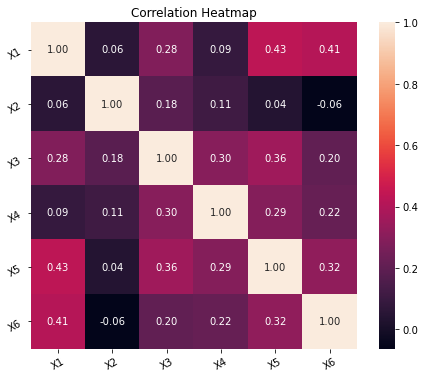

In [3]:
#Correlation

corr_matrix = X.corr()

#Plot Heatmap

plt.figure(figsize=(8,6))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show() 

In [4]:
#Drop columns with high correlation.

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.4)]
print(to_drop)

['X5', 'X6']


In [5]:
#ANOVA F Value

fvalue_selector = SelectKBest(f_classif, k=2)

X_kbest = fvalue_selector.fit_transform(X, y)

X_kbest

array([[3, 2],
       [3, 4],
       [5, 3],
       [5, 3],
       [5, 3],
       [5, 5],
       [3, 1],
       [5, 4],
       [4, 4],
       [4, 5],
       [3, 2],
       [4, 4],
       [5, 5],
       [4, 4],
       [4, 4],
       [3, 4],
       [5, 4],
       [5, 4],
       [5, 4],
       [4, 4],
       [4, 4],
       [4, 5],
       [4, 5],
       [5, 2],
       [4, 3],
       [3, 2],
       [3, 5],
       [3, 3],
       [3, 3],
       [5, 5],
       [5, 5],
       [4, 4],
       [3, 4],
       [3, 4],
       [4, 1],
       [4, 4],
       [5, 4],
       [5, 4],
       [5, 2],
       [4, 2],
       [5, 3],
       [4, 2],
       [5, 4],
       [4, 2],
       [3, 3],
       [5, 4],
       [5, 4],
       [1, 1],
       [5, 5],
       [5, 4],
       [5, 4],
       [5, 4],
       [5, 4],
       [5, 4],
       [4, 3],
       [4, 3],
       [5, 3],
       [4, 3],
       [5, 4],
       [5, 2],
       [4, 3],
       [5, 5],
       [5, 5],
       [5, 5],
       [4, 4],
       [4, 4],
       [3,

In [6]:
#Keep X1 and X5.

## 1.1 Logistic Regression

In [7]:
kf = KFold(n_splits=6, shuffle=True, random_state=1)

logreg = LogisticRegression()

scores = cross_val_score(logreg, X, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (include all): {np.mean(scores)*100}%')

#Drop by variance.

columns = ['X2', 'X3', 'X5']
X_drop_var = data[columns]

scores = cross_val_score(logreg, X_drop_var, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (variance): {np.mean(scores)*100}%')

#Drop by correlation.

columns = ['X1', 'X2', 'X3', 'X4']
X_drop_corr = data[columns]

scores = cross_val_score(logreg, X_drop_corr, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (corralation): {np.mean(scores)*100}%')

#Keep by ANOVA

columns = ['X1', 'X5']
X_keep_ANOVA = data[columns]

scores = cross_val_score(logreg, X_keep_ANOVA, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (ANOVA): {np.mean(scores)*100}%')

Accuracy (include all): 52.38095238095239%
Accuracy (variance): 53.96825396825397%
Accuracy (corralation): 53.96825396825397%
Accuracy (ANOVA): 57.14285714285713%


## 1.2 XGBoost

In [8]:
xgb = XGBClassifier()

scores = cross_val_score(xgb, X, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (include all): {np.mean(scores)*100}%')

#Drop by variance.

scores = cross_val_score(xgb, X_drop_var, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (variance): {np.mean(scores)*100}%')

#Drop by correlation.

scores = cross_val_score(xgb, X_drop_corr, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (correlation): {np.mean(scores)*100}%')

#Keep by ANOVA

scores = cross_val_score(xgb, X_keep_ANOVA, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (ANOVA): {np.mean(scores)*100}%')

Accuracy (include all): 60.317460317460316%
Accuracy (variance): 53.17460317460318%
Accuracy (correlation): 53.96825396825397%
Accuracy (ANOVA): 63.49206349206349%


## 1.3 KNN

In [9]:
knn = KNeighborsClassifier(n_neighbors=15)

scores = cross_val_score(knn, X, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (include all): {np.mean(scores)*100}%')

#Drop by variance.

scores = cross_val_score(knn, X_drop_var, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (variance): {np.mean(scores)*100}%')

#Drop by correlation.

scores = cross_val_score(knn, X_drop_corr, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (correlation): {np.mean(scores)*100}%')

#Keep by ANOVA

scores = cross_val_score(knn, X_keep_ANOVA, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (ANOVA): {np.mean(scores)*100}%')

Accuracy (include all): 57.14285714285715%
Accuracy (variance): 53.96825396825397%
Accuracy (correlation): 50.0%
Accuracy (ANOVA): 60.317460317460316%


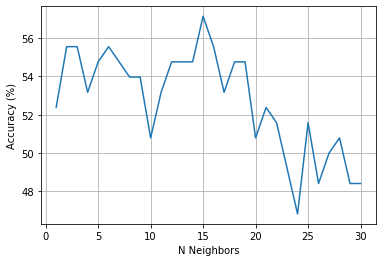

In [10]:
N = []
scores = []
for n in range(1,31):
    N.append(n)
    knn = KNeighborsClassifier(n_neighbors=n)
    scores.append(np.mean(cross_val_score(knn, X, y, scoring='accuracy', cv=kf, n_jobs=-1))*100)
    
plt.plot(N, scores)
plt.xlabel('N Neighbors')
plt.ylabel('Accuracy (%)')
plt.grid(True)

## 1.4 Decision Tree

In [11]:
tree = DecisionTreeClassifier()

scores = cross_val_score(tree, X, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (include all): {np.mean(scores)*100}%')

#Drop by variance.

scores = cross_val_score(tree, X_drop_var, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (variance): {np.mean(scores)*100}%')

#Drop by correlation.

scores = cross_val_score(tree, X_drop_corr, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (correlation): {np.mean(scores)*100}%')

#Keep by ANOVA

scores = cross_val_score(tree, X_keep_ANOVA, y, scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy (ANOVA): {np.mean(scores)*100}%')

Accuracy (include all): 57.14285714285714%
Accuracy (variance): 51.587301587301596%
Accuracy (correlation): 56.34920634920635%
Accuracy (ANOVA): 64.28571428571429%


## 2.0 HP Optimisation

In [12]:
space = {'eta': hp.uniform('eta', 0, 1),
         'gamma': hp.uniform('gamma', 0, 10),
         'max_depth': hp.quniform('max_depth', 1, 20, 1),
         'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
         'seed': 0}

def objective(space):
    clf=XGBClassifier(eta=space['eta'],
                      gamma=space['gamma'],
                      max_depth=int(space['max_depth']),
                      min_child_weight=int(space['min_child_weight'])
                     )
    
    scores = cross_val_score(clf, X_keep_ANOVA, y, 
                             scoring='accuracy', cv=kf, n_jobs=-1)
    acc = np.mean(scores)
    
    print(f'Score: {acc}')
    return {'loss':-acc, 'status': STATUS_OK}

In [13]:
trials = Trials()

opt = fmin(fn=objective, 
           space=space,
           algo=tpe.suggest,
           max_evals=100,
           trials=trials)

Score: 0.5317460317460317                              
Score: 0.6428571428571429                                                         
Score: 0.5793650793650794                                                         
Score: 0.5238095238095238                                                         
Score: 0.5317460317460317                                                         
Score: 0.5238095238095238                                                         
Score: 0.5317460317460317                                                         
Score: 0.6428571428571429                                                         
Score: 0.5317460317460317                                                         
Score: 0.5238095238095238                                                         
Score: 0.6031746031746031                                                         
Score: 0.5317460317460317                                                          
Score: 0.6507936507936508     

In [14]:
print(opt)

{'eta': 0.839945319302015, 'gamma': 2.7184026276301116, 'max_depth': 18.0, 'min_child_weight': 2.0}


In [15]:
xgb_opt = XGBClassifier(eta=opt['eta'], 
                        gamma=opt['gamma'],
                        max_depth=int(opt['max_depth']),
                        min_child_weight=int(opt['min_child_weight'])
                       )

scores = cross_val_score(xgb_opt, X_keep_ANOVA, y, 
                         scoring='accuracy', cv=kf, n_jobs=-1)
print(f'Accuracy: {np.mean(scores)*100}%')
print(scores)

Accuracy: 67.46031746031746%
[0.71428571 0.61904762 0.52380952 0.61904762 0.80952381 0.76190476]


## 3.0 Model Explanation

In [29]:
#Fit model
columns = ['X1', 'X5']
X = data[columns]
y = data['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.839945319302015, eval_metric=None, gamma=2.7184026276301116,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.839945316,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=18,
              max_leaves=0, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [30]:
#Get shap values.
exp = shap.TreeExplainer(xgb_opt)
shap_values_test = exp.shap_values(X_test)
shap_values_train = exp.shap_values(X_train)

df_shap_test = pd.DataFrame(shap_values_test, columns=X_test.columns.values)
df_shap_train = pd.DataFrame(shap_values_train, columns=X_train.columns.values)

In [31]:
#Initialize
j = 0
shap.initjs

categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()

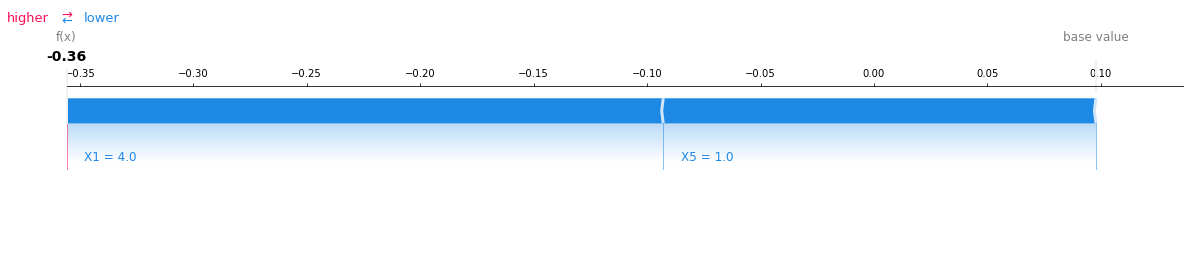

In [32]:
shap.force_plot(exp.expected_value, shap_values_test[j], X_test.iloc[[j]], matplotlib=True)

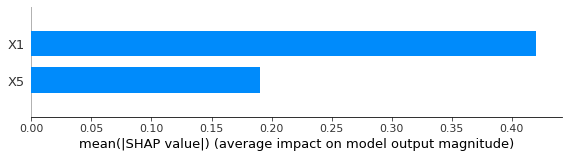

In [33]:
shap.summary_plot(shap_values_train, X_train, plot_type='bar')

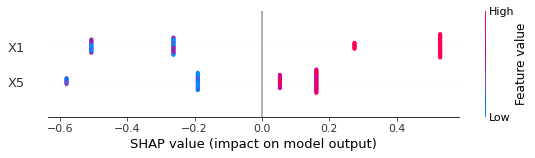

In [34]:
shap.summary_plot(shap_values_train, X_train)

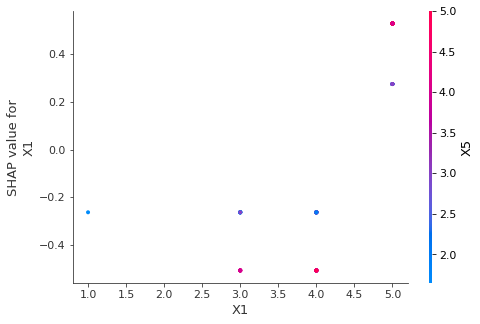

In [36]:
shp_plt = shap.dependence_plot('X1', shap_values_train, X_train)

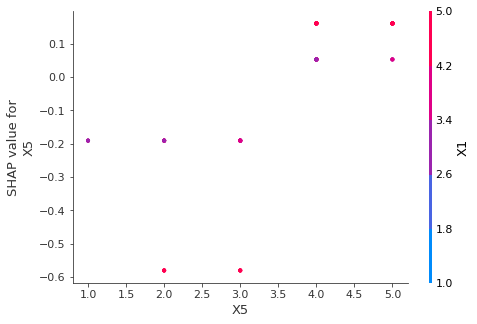

In [37]:
shp_plt = shap.dependence_plot('X5', shap_values_train, X_train)